In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, get_1_dev_irr

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Equation 10 from Suzuki

$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    + r^2\alpha_{\phi z}(\rho c_s^2)_{\textrm{mid}}
    \right\}\right]
    + C_{\textrm{w}}(\rho c_s)_{\textrm{mid}}
    \;=\;0$$

$$
\Omega\approx\Omega_K=\sqrt{\frac{GM_*}{r^3}}
$$    

$$
c_s^2=\frac{k_BT}{\mu m_H}
$$

#### Neglecting disc wind and torque:
$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    \right\}\right]
    
    \;=\;0$$

#### From B.10:
$$\sigma_\textrm{SB}T^4=\frac{3}{4}\Omega\Sigma\bar{\alpha_{r\phi}}c_s^2$$

$$\Rightarrow \quad c_s^6\;=\;\frac{1}{\sigma_\textrm{SB}}
\left(\frac{\mu m_{H}}{K_B}\right)^{-4}
\frac{3}{4}\Omega\Sigma \bar{\alpha_{r\phi}}
$$

In [7]:
μ = 2.34    #(Hayashi 1981)

In [8]:
def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

In [9]:
r = r_array * u.au
c_s(Omega_kep(r), Σ_initial(r))[0]

<Quantity 9063.54972517 m / s>

### Imposing the boundary condition $\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$

$$\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$$
$$\Rightarrow\frac{\partial}{\partial r}(\Sigma)\cdot r^{3/2}\;+\;\frac{3}{2}\Sigma r^{1/2}=0$$
$$\Sigma r^{2}=-\frac{2}{3}\;r^{3}\;\frac{\partial}{\partial r}\Sigma$$


In [85]:
α_rφ = 8e-3


def one_alpha_diff(Σ):
    boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

AttributeError: 'float' object has no attribute 'unit'

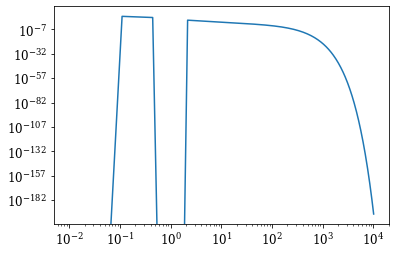

In [93]:
plt.loglog(r_array, one_alpha_diff(Σ_initial(r)))
(float(1)).unit


In [108]:
α_rφ = 8e-3
def one_alpha_diff(t, Σ):
    if isinstance(Σ, np.ndarray):
        Σ = Σ *  u.g * u.cm**-2
    boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

#### "one_alpha_diff" return in terms of:
$$\left[\frac{g}{cm^2}\frac{1}{kyr}\right]$$

In [109]:
times = np.arange(1000)
sol = solve_ivp(one_alpha_diff, [times[0], times[-1]], y0 = Σ_initial(r), t_eval = times, method = 'LSODA')

C:\Users\chris\anaconda3\lib\site-packages\astropy\units\quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\chris\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [113]:
np.shape(sol.y)

(205, 1)

In [106]:
isinstance(r_array, np.ndarray)

True